<a href="https://colab.research.google.com/github/asheta66/Machine-Learning-2024/blob/main/Classification/GNB_Cardiovascular_Diseases_Age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# !pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

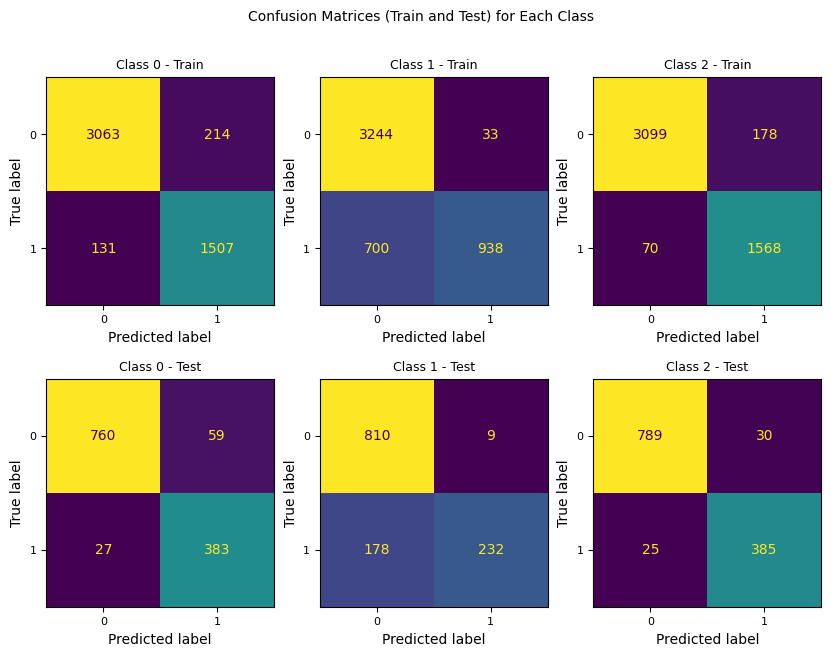

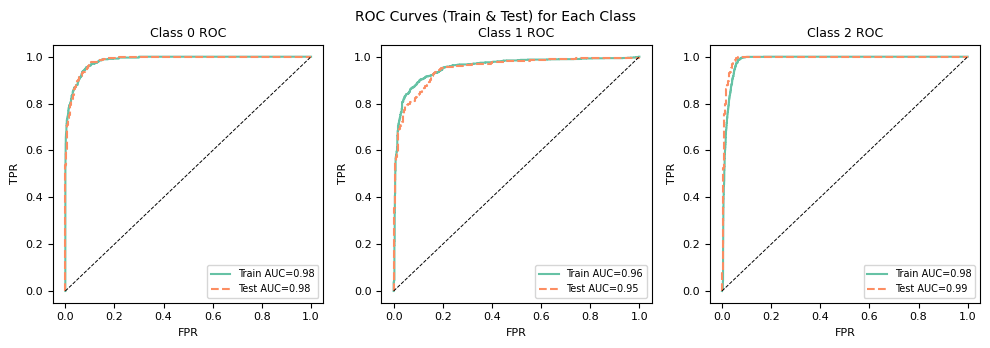

In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

# Create output directory
output_dir = "output_figures_age_class"
os.makedirs(output_dir, exist_ok=True)

# Load dataset
df = pd.read_csv('framingham.csv')
df.dropna(inplace=True)

# Define age class
def age_group(age):
    if age < 40:
        return 0  # Young
    elif age < 55:
        return 1  # Middle-aged
    else:
        return 2  # Older

df['age_class'] = df['age'].apply(age_group)

# Drop unneeded columns
if 'TenYearCHD' in df.columns:
    df.drop(columns=['TenYearCHD'], inplace=True)

# Prepare features and labels
X = df.drop(columns=['age_class'])
y = df['age_class']

# Balance all classes equally
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Initialize storage
metrics_list = []

# Setup for plots
fig_cm, axes_cm = plt.subplots(2, 3, figsize=(10, 7))
fig_roc, axes_roc = plt.subplots(1, 3, figsize=(10, 3.5))
cmap = cm.get_cmap("Set2")

# Process each class as one-vs-rest
for cls in [0, 1, 2]:
    class_label = f'Class {cls}'
    y_binary = (y_res == cls).astype(int)

    # Feature selection
    selector = SelectKBest(score_func=chi2, k=7)
    X_selected = selector.fit_transform(X_res, y_binary)
    top_features = X.columns[selector.get_support()]

    # Standardization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_selected)

    # Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_binary, test_size=0.2, random_state=23, stratify=y_binary
    )

    # Train model
    param_grid = {'var_smoothing': np.logspace(-11, -8, 10)}
    grid = GridSearchCV(GaussianNB(), param_grid, cv=5)
    grid.fit(X_train, y_train)
    model = grid.best_estimator_

    # Predict
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Store metrics
    for phase, y_true, y_pred in [('Train', y_train, y_train_pred), ('Test', y_test, y_test_pred)]:
        metrics_list.append({
            'Class': cls,
            'Phase': phase,
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred, zero_division=0),
            'Recall': recall_score(y_true, y_pred, zero_division=0),
            'F1-Score': f1_score(y_true, y_pred, zero_division=0)
        })

    # Confusion Matrices
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test)
    disp_train.plot(ax=axes_cm[0, cls], colorbar=False)
    disp_test.plot(ax=axes_cm[1, cls], colorbar=False)
    axes_cm[0, cls].set_title(f'{class_label} - Train', fontsize=9)
    axes_cm[1, cls].set_title(f'{class_label} - Test', fontsize=9)
    axes_cm[0, cls].tick_params(labelsize=8)
    axes_cm[1, cls].tick_params(labelsize=8)

    # ROC Curves
    y_score_train = model.predict_proba(X_train)[:, 1]
    y_score_test = model.predict_proba(X_test)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    auc_train = auc(fpr_train, tpr_train)
    auc_test = auc(fpr_test, tpr_test)

    ax = axes_roc[cls]
    ax.plot(fpr_train, tpr_train, label=f'Train AUC={auc_train:.2f}', color=cmap(0))
    ax.plot(fpr_test, tpr_test, label=f'Test AUC={auc_test:.2f}', color=cmap(1), linestyle='--')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=0.7)
    ax.set_title(f'{class_label} ROC', fontsize=9)
    ax.set_xlabel('FPR', fontsize=8)
    ax.set_ylabel('TPR', fontsize=8)
    ax.legend(fontsize=7)
    ax.tick_params(axis='both', labelsize=8)

# Save confusion matrix figure
fig_cm.suptitle('Confusion Matrices (Train and Test) for Each Class', fontsize=10)
plt.tight_layout()
fig_cm.subplots_adjust(top=0.90)
fig_cm.savefig(os.path.join(output_dir, 'age_class_conf_matrices.png'))

# Save ROC curve figure
fig_roc.suptitle('ROC Curves (Train & Test) for Each Class', fontsize=10)
plt.tight_layout()
fig_roc.subplots_adjust(top=0.88)
fig_roc.savefig(os.path.join(output_dir, 'age_class_roc_curves.png'))

# Save metrics to CSV
df_metrics = pd.DataFrame(metrics_list)
df_metrics.to_csv(os.path.join(output_dir, 'performance_metrics.csv'), index=False)


In [47]:
# Save metrics
df_metrics = pd.DataFrame(metrics_list).round(4)
df_metrics.to_csv(os.path.join(output_dir, 'metrics_age_class.csv'), index=False)
print("\n📊 Metrics saved to 'metrics_age_class.csv'")
df_metrics


📊 Metrics saved to 'metrics_age_class.csv'


,Class,Phase,Accuracy,Precision,Recall,F1-Score
0,0,Train,0.9298,0.8757,0.9200,0.8973
1,0,Test,0.9300,0.8665,0.9341,0.8991
2,1,Train,0.8509,0.9660,0.5726,0.7190
3,1,Test,0.8478,0.9627,0.5659,0.7127
4,2,Train,0.9495,0.8981,0.9573,0.9267
5,2,Test,0.9552,0.9277,0.9390,0.9333
